In [2]:
!python3 -V

Python 3.10.0


# Setup

## Dependencies

In [3]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
# import tqdm.notebook as tqdm
import tqdm
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

/opt/conda/envs/sprint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
act_name = 'mlp_out'

## Defining the Autoencoder

In [5]:
DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        try:
            d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
            d_mlp = cfg["d_mlp"]
        except KeyError:
            d_hidden = cfg['dict_size']
            d_mlp = d_hidden//cfg['dict_mult']
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

    @classmethod
    def load_from_hf(cls, version):
        """
        Loads the saved autoencoder from HuggingFace.

        Version is expected to be an int, or "run1" or "run2"

        version 25 is the final checkpoint of the first autoencoder run,
        version 47 is the final checkpoint of the second autoencoder run.
        """
        if version=="run1":
            version = 25
        elif version=="run2":
            version = 47

        cfg = utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}_cfg.json")
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}.pt", force_is_torch=True))
        return self


## Utils

### Get Reconstruction Loss

In [6]:
def replacement_hook(mlp_post, hook, encoder):
    mlp_post_reconstr = encoder(mlp_post)[1]
    return mlp_post_reconstr

def mean_ablate_hook(mlp_post, hook):
    mlp_post[:] = mlp_post.mean([0, 1])
    return mlp_post

def zero_ablate_hook(mlp_post, hook):
    mlp_post[:] = 0.
    return mlp_post

@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    for i in range(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:batch_size]]
        loss = model(tokens, return_type="loss")
        recons_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss

### Get Frequencies

In [7]:
# Frequency
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None, act_name=act_name, layer=0):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()
    total = 0
    # for i in tqdm.trange(num_batches):
    for i in range(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:batch_size]]

        _, cache = model.run_with_cache(tokens, names_filter=utils.get_act_name(act_name, layer))
        mlp_acts = cache[utils.get_act_name(act_name, layer)]
        mlp_acts = mlp_acts.reshape(-1, local_encoder.W_enc.shape[0])

        hidden = local_encoder(mlp_acts)[2]

        act_freq_scores += (hidden > 0).sum(0)
        total+=hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores==0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

## Visualise Feature Utils

In [8]:
from html import escape
import colorsys

from IPython.display import display

SPACE = "·"
NEWLINE="↩"
TAB = "→"

def create_html(strings, values, max_value=None, saturation=0.5, allow_different_length=False, return_string=False):
    # escape strings to deal with tabs, newlines, etc.
    escaped_strings = [escape(s, quote=True) for s in strings]
    processed_strings = [
        s.replace("\n", f"{NEWLINE}<br/>").replace("\t", f"{TAB}&emsp;").replace(" ", "&nbsp;")
        for s in escaped_strings
    ]

    if isinstance(values, torch.Tensor) and len(values.shape)>1:
        values = values.flatten().tolist()

    if not allow_different_length:
        assert len(processed_strings) == len(values)

    # scale values
    if max_value is None:
        max_value = max(max(values), -min(values))+1e-3
    scaled_values = [v / max_value * saturation for v in values]

    # create html
    html = ""
    for i, s in enumerate(processed_strings):
        if i<len(scaled_values):
            v = scaled_values[i]
        else:
            v = 0
        if v < 0:
            hue = 0  # hue for red in HSV
        else:
            hue = 0.66  # hue for blue in HSV
        rgb_color = colorsys.hsv_to_rgb(
            hue, v, 1
        )  # hsv color with hue 0.66 (blue), saturation as v, value 1
        hex_color = "#%02x%02x%02x" % (
            int(rgb_color[0] * 255),
            int(rgb_color[1] * 255),
            int(rgb_color[2] * 255),
        )
        html += f'<span style="background-color: {hex_color}; border: 1px solid lightgray; font-size: 16px; border-radius: 3px;">{s}</span>'
    if return_string:
        return html
    else:
        display(HTML(html))

def basic_feature_vis(text, feature_index, max_val=0):
    feature_in = encoder.W_enc[:, feature_index]
    feature_bias = encoder.b_enc[feature_index]
    _, cache = model.run_with_cache(text, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
    mlp_acts = cache[utils.get_act_name("post", 0)][0]
    feature_acts = F.relu((mlp_acts - encoder.b_dec) @ feature_in + feature_bias)
    if max_val==0:
        max_val = max(1e-7, feature_acts.max().item())
        # print(max_val)
    # if min_val==0:
    #     min_val = min(-1e-7, feature_acts.min().item())
    return basic_token_vis_make_str(text, feature_acts, max_val)
def basic_token_vis_make_str(strings, values, max_val=None):
    if not isinstance(strings, list):
        strings = model.to_str_tokens(strings)
    values = utils.to_numpy(values)
    if max_val is None:
        max_val = values.max()
    # if min_val is None:
    #     min_val = values.min()
    header_string = f"<h4>Max Range <b>{values.max():.4f}</b> Min Range: <b>{values.min():.4f}</b></h4>"
    header_string += f"<h4>Set Max Range <b>{max_val:.4f}</b></h4>"
    # values[values>0] = values[values>0]/ma|x_val
    # values[values<0] = values[values<0]/abs(min_val)
    body_string = create_html(strings, values, max_value=max_val, return_string=True)
    return header_string + body_string
# display(HTML(basic_token_vis_make_str(tokens[0, :10], mlp_acts[0, :10, 7], 0.1)))
# # %%
# The `with gr.Blocks() as demo:` syntax just creates a variable called demo containing all these components


### Inspecting Top Logits

In [9]:
SPACE = "·"
NEWLINE="↩"
TAB = "→"
def process_token(s):
    if isinstance(s, torch.Tensor):
        s = s.item()
    if isinstance(s, np.int64):
        s = s.item()
    if isinstance(s, int):
        s = model.to_string(s)
    s = s.replace(" ", SPACE)
    s = s.replace("\n", NEWLINE+"\n")
    s = s.replace("\t", TAB)
    return s

def process_tokens(l):
    if isinstance(l, str):
        l = model.to_str_tokens(l)
    elif isinstance(l, torch.Tensor) and len(l.shape)>1:
        l = l.squeeze(0)
    return [process_token(s) for s in l]

def process_tokens_index(l):
    if isinstance(l, str):
        l = model.to_str_tokens(l)
    elif isinstance(l, torch.Tensor) and len(l.shape)>1:
        l = l.squeeze(0)
    return [f"{process_token(s)}/{i}" for i,s in enumerate(l)]

def create_vocab_df(logit_vec, make_probs=False, full_vocab=None):
    if full_vocab is None:
        full_vocab = process_tokens(model.to_str_tokens(torch.arange(model.cfg.d_vocab)))
    vocab_df = pd.DataFrame({"token": full_vocab, "logit": utils.to_numpy(logit_vec)})
    if make_probs:
        vocab_df["log_prob"] = utils.to_numpy(logit_vec.log_softmax(dim=-1))
        vocab_df["prob"] = utils.to_numpy(logit_vec.softmax(dim=-1))
    return vocab_df.sort_values("logit", ascending=False)

### Make Token DataFrame

In [10]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]
def make_token_df(tokens, len_prefix=5, len_suffix=1):
    str_tokens = [process_tokens(model.to_str_tokens(t)) for t in tokens]
    unique_token = [[f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens]

    context = []
    batch = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        # context.append([])
        # batch.append([])
        # pos.append([])
        # label.append([])
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p==tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            batch.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        unique_token=list_flatten(unique_token),
        context=context,
        batch=batch,
        pos=pos,
        label=label,
    ))

## Loading the Model

In [11]:
model = HookedTransformer.from_pretrained("gelu-2l").to(torch.float32)
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

Loaded pretrained model gelu-2l into HookedTransformer
Changing model dtype to torch.float32


In [12]:
batch_size = 64

## Loading Data

In [13]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

In [14]:
print(all_tokens[0])

tensor([    1,    10, 27498, 29989,    65,  7147,    14, 29808,    11,   647,
          603,   417,  7481,    16,  3839,    16,  5635,   344,    10, 37123,
           65,  7147,  2192,   926,  6975, 36779, 34907,   255,  4608,  1551,
         2231, 17960, 38309,    18, 15553,  1102,   276, 41727,   347, 28881,
          347, 25859,   550,    19,  8983, 27498, 29989,  3333, 28881,  5811,
           10, 37123,    14,  1827,    16, 29902,    65,  2137,    65,  7147,
         1210,   647, 30343,    65, 22338,   426,   867,    10,   784,    65,
        22338,    10, 27498, 29989,    65,  7147,    14,   791, 10694,   567,
         6087, 14307,   647,  7876,    65,   927,    65, 32489,   426,  7954,
          647,   324,  2951,   276, 30343,    65, 22338,    28,   926,  7876,
           65,   927,    65, 32489,    16, 30777,    10,  1262,  3226,   784,
           65, 32737,    65,  3933,    65, 22968,    10,  4352,  1210,  2621,
         4311,    65, 32737,    65,   927,    65, 32489,   426])

# Analysis

## Loading the Autoencoder

There are two runs on separate random seeds, along with a bunch of intermediate checkpoints

In [15]:
encoder_l1 = AutoEncoder.load_from_hf("gelu-2l_L1_16384_mlp_out_50")

{'act_name': 'blocks.1.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'device': 'cuda:0',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 1,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 50,
 'seq_len': 128,
 'site': 'mlp_out'}


## Using the Autoencoder

In [16]:
freqs = get_freqs(num_batches = 50, local_encoder = encoder_l1, act_name='mlp_out', layer=1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.47 GiB. GPU 0 has a total capacty of 22.16 GiB of which 1.19 GiB is free. Process 3816242 has 20.18 GiB memory in use. Process 3908249 has 796.00 MiB memory in use. Of the allocated memory 321.06 MiB is allocated by PyTorch, and 18.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
common_indices = torch.arange(encoder_l1.W_enc.shape[1]).to("cuda")[freqs > 1e-4]

In [ ]:
common_indices[:50]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       device='cuda:0')

# Feature interpretation

In [17]:
# feature_id = 7 # @param {type:"number"}
batch_size = 64 # @param {type:"number"}

print(f"Feature freq: {freqs[7].item():.4f}")

NameError: name 'freqs' is not defined

Let's run the model on some text and then use the autoencoder to process the MLP activations

In [ ]:
def get_feature_scores(model, encoder, tokens_arr, feature_idx, batch_size=64, act_name=act_name, layer=0):
  scores = []
  for i in tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size)):
    #print(i, tokens_arr.shape[0], batch_size)
    with torch.no_grad():
      _, cache = model.run_with_cache(tokens_arr[i:i+batch_size], names_filter=[
        utils.get_act_name(act_name, layer)
      ])
      mlp_acts = cache[utils.get_act_name(act_name, layer)]
      mlp_acts_flattened = mlp_acts.reshape(-1, encoder.W_enc.shape[0])
      loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)

    scores.append(utils.to_numpy(hidden_acts[:, feature_idx].reshape(batch_size, tokens_arr.shape[1])).astype(np.float16))
  return np.concatenate(scores)


In [ ]:
def get_dot_scores(model, tokens_arr, range_normal, batch_size=64, act_name=act_name, layer=0):
  scores = []
  for i in tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size)):
    #print(i, tokens_arr.shape[0], batch_size)
    with torch.no_grad():
      _, cache = model.run_with_cache(tokens_arr[i:i+batch_size], names_filter=[
        utils.get_act_name(act_name, layer)
      ])
      mlp_acts = cache[utils.get_act_name(act_name, layer)]
      mlp_acts_flattened = mlp_acts.reshape(-1, mlp_acts.shape[-1])
      cur_scores = mlp_acts_flattened @ range_normal

    scores.append(utils.to_numpy(cur_scores).astype(np.float16))
  return np.concatenate(scores)


In [ ]:
scores = get_feature_scores(model, encoder_l1, all_tokens[:128*100], 8, batch_size=128, layer=1)

  1%|          | 1/100 [00:00<00:24,  4.04it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.95 GiB. GPU 0 has a total capacty of 22.16 GiB of which 2.77 GiB is free. Process 3529685 has 9.73 GiB memory in use. Process 3537465 has 9.65 GiB memory in use. Of the allocated memory 7.30 GiB is allocated by PyTorch, and 1.91 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
scores.shape

(12800, 128)

In [ ]:
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
1608723,·',·'/19,"',↩ ············'city':|·'|Be",12568,19,12568/19,7.277344
788886,·',·'/22,"',↩ ············'name':|·'|Arthur",6163,22,6163/22,6.656250
253044,·',·'/116,·{↩ ············'id':|·'|5,1976,116,1976/116,6.472656
995947,·',·'/107,"',↩ ········'name':|·'|Arthur",7780,107,7780/107,6.437500
120395,·',·'/75,"',·**{'family':|·'|serif",940,75,940/75,6.414062
576401,·',·'/17,2106':|·'|s,4503,17,4503/17,6.375000
1144463,·',·'/15,"·None,·'name':|·'|mock",8941,15,8941/15,6.355469
1614359,·',·'/23,·{↩ ········'title':|·'|Gall,12612,23,12612/23,6.269531
788879,·',·'/15,·{↩ ············'title':|·'|King,6163,15,6163/15,6.261719
187870,·',·'/94,"email,·'title':|·'|fo",1467,94,1467/94,6.207031


In [18]:
feature_idx = 8 # @param {type:"number"}

## Feature interpretation

In [ ]:
def get_feature_scores_for_prompt(model, encoder, prompt, feature, act_name=act_name, layer=0, prepend_bos=True):
  with torch.no_grad():
    _, cache = model.run_with_cache(prompt, names_filter=[
      utils.get_act_name(act_name, layer)
    ], prepend_bos=prepend_bos)
    acts = cache[utils.get_act_name(act_name, layer)]
    acts = acts.reshape(-1, encoder.W_enc.shape[0])
    loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(acts)
  return utils.to_numpy(hidden_acts[:, feature])

# Feature propagation

In [19]:
feature_example_idx = 12568
feature_token_idx = 19

In [ ]:
all_tokens[feature_example_idx][feature_token_idx] 

tensor(684)

### Linearize through MLP1

In [ ]:
def get_tangent_plane_at_point(x_0_new, f, range_normal):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    return grad[0]

In [20]:
feature_l1_out = encoder_l1.W_enc[:, feature_idx]

In [ ]:
def ln2_mlp_until_post(x, ln, mlp, use_ln=True):
  if use_ln:
    x = ln(x)
  x = x @ mlp.W_in + mlp.b_in
  x = mlp.act_fn(x)
  return x

def ln2_mlp_until_out(x, ln, mlp, use_ln=True):
  if use_ln:
    x = ln(x)
  return mlp(x)

In [21]:
def get_feature_mid(all_tokens, feature_example_idx, feature_token_idx, feature_post, use_ln=True, layer=0, mlp_out=True):
    with torch.no_grad():
        _, cache = model.run_with_cache(all_tokens[feature_example_idx], names_filter=[
          utils.get_act_name("resid_mid", layer)
        ])
    mid_acts = cache[utils.get_act_name("resid_mid", layer)]
    x_mid = mid_acts[0, feature_token_idx][None, None, :]
    
    my_fun = (ln2_mlp_until_post if not mlp_out else ln2_mlp_until_out)
    feature_mid = get_tangent_plane_at_point(x_mid,
        lambda x: my_fun(x, model.blocks[layer].ln2, model.blocks[layer].mlp, use_ln=use_ln),
        feature_post
    )[0,0]
    return feature_mid

In [22]:
def get_feature_mid_at_prompt(prompt, feature_token_idx, feature_post, use_ln=True, layer=0, mlp_out=True):
    with torch.no_grad():
        _, cache = model.run_with_cache(prompt, names_filter=[
          utils.get_act_name("resid_mid", layer)
        ])
    mid_acts = cache[utils.get_act_name("resid_mid", layer)]
    x_mid = mid_acts[0, feature_token_idx][None, None, :]
    
    my_fun = (ln2_mlp_until_post if not mlp_out else ln2_mlp_until_out)
    feature_mid = get_tangent_plane_at_point(x_mid,
        lambda x: my_fun(x, model.blocks[layer].ln2, model.blocks[layer].mlp, use_ln=use_ln),
        feature_post
    )[0,0]
    return feature_mid

In [23]:
def cossim(a, b, item=False):
    x = torch.dot(a,b)/(torch.linalg.norm(a)*torch.linalg.norm(b))
    if item: return x.item()
    return x

In [24]:
def get_tangent_plane_at_point(x_0_new, f, range_normal):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    return grad[0]


def ln2_mlp_until_post(x, ln, mlp, use_ln=True):
    if use_ln:
        x = ln(x)
    x = x @ mlp.W_in + mlp.b_in
    x = mlp.act_fn(x)
    return x


def ln2_mlp_until_out(x, ln, mlp, use_ln=True):
    if use_ln:
        x = ln(x)
    return mlp(x)


def get_feature_mid(
    all_tokens, feature_example_idx, feature_token_idx, feature_post, use_ln=True, layer=0, mlp_out=True
):
    with torch.no_grad():
        _, cache = model.run_with_cache(
            all_tokens[feature_example_idx], names_filter=[utils.get_act_name("resid_mid", layer)]
        )
    mid_acts = cache[utils.get_act_name("resid_mid", layer)]
    x_mid = mid_acts[0, feature_token_idx][None, None, :]

    my_fun = ln2_mlp_until_post if not mlp_out else ln2_mlp_until_out
    feature_mid = get_tangent_plane_at_point(
        x_mid, lambda x: my_fun(x, model.blocks[layer].ln2, model.blocks[layer].mlp, use_ln=use_ln), feature_post
    )[0, 0]
    return feature_mid

In [ ]:
all_tokens[feature_example_idx]

tensor([    1,  1029,    28,   550,   926,   684, 17838,  5141,   684,   614,
           14, 13949,    14, 16778,  1358,   926,   684, 20644,  5141,   684,
         4534, 16279,    14,  2721,   605, 16458,    14, 22914,  3522,    14,
           37, 36691,  1358,   926,   684,   486,  5141,   684,    19,    26,
           28,    22,    23,  1358,   926,   684, 20439,  5141,   684,    79,
           14,    72,  1358,   926,   684, 24200,  1426,  5141,   684,    18,
           14,    19,  1358,   926,   684,  6923,    65,  7384, 12238,  5141,
          684,    91,  1358,   926,   684, 37674,    65, 20894,  5141,   684,
           91,    14,    80,  1358,   926,   684,  5530,  5141,   684,    80,
            9,   647,   210, 11777,   647,  1827,    16,  8052,    65, 13575,
           65, 46012,  2555,    85,  1067,  1465,   804,  1056,    65, 13575,
           65, 20349,    65, 11806,    65,  3014,    65,    22,    65, 37253,
          932,    10,  1262,  2192,   647,   765,   426,  1827])

In [ ]:
from sprint.loading import load_all

# model, all_tokens, encoder_l1 = load_all(model_name="gelu-2l", run_id="l1")
model, all_tokens, _ = load_all(model_name="gelu-2l", run_id="l1", use_half=False)

Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading l1 from HuggingFace at gelu-2l_L1_16384_mlp_out_50
{'act_name': 'blocks.1.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 512,
 'device': 'cuda:0',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 1,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 50,
 'seq_len': 128,
 'site': 'mlp_out'}
Encoder device: cuda:0


In [ ]:
feature_mid1_noln = get_feature_mid(all_tokens, feature_example_idx, feature_token_idx, feature_l1_out.half(), use_ln=False, layer=1, mlp_out=True)
feature_mid1_noln[:10]

tensor([-0.0864,  0.2024,  0.0554, -0.2052,  0.1033, -0.0175,  0.1244,  0.0026,
         0.0464,  0.0484], device='cuda:0', dtype=torch.float16)

In [ ]:
feature_mid1 = get_feature_mid(all_tokens, feature_example_idx, feature_token_idx, feature_l1_out.half(), use_ln=True, layer=1, mlp_out=True)
feature_mid1[:10]

tensor([ 0.1122,  0.1810,  0.0796, -0.0917,  0.1187, -0.0566,  0.0297,  0.0187,
         0.0669,  0.0425], device='cuda:0', dtype=torch.float16)

In [ ]:
cossim(feature_mid1_noln, feature_mid1)

tensor(0.6963, device='cuda:0', dtype=torch.float16)

### Unembed feature

Before investigating attention, first, see if directly unembedding the feature yields us anything.

In [ ]:
feature_unembed = model.W_E @ feature_mid1_noln

In [ ]:
def get_top_tokens(tokenizer, vector, k=5, reverse=False):
  topk = torch.topk(vector, k=k, largest=(not reverse))
  return topk.values, tokenizer.batch_decode(
      [ [x] for x in topk.indices ]
  )

In [ ]:
def plot_top_tokens(model, unembedded_feature, k=10):
  token_scores, token_strs = get_top_tokens(model.tokenizer, unembedded_feature, k=k)

  token_df = pd.DataFrame(dict(
    str_tokens = process_tokens(token_strs),
    feature_scores = token_scores.detach().cpu().numpy()
  ))
  token_df = token_df.style.background_gradient("coolwarm")
  display(token_df)

In [ ]:
plot_top_tokens(model, model.W_E @ feature_mid1_noln)

,str_tokens,feature_scores
0,·inex,2.837564
1,·έ,2.825871
2,·immer,2.710496
3,·veh,2.666833
4,·iç,2.615569
5,ή,2.587063
6,·ec,2.560903
7,·contin,2.558813
8,·reign,2.553266
9,·ris,2.546016


In [ ]:
plot_top_tokens(model, model.W_E @ feature_mid1)

,str_tokens,feature_scores
0,·inex,2.119159
1,·ec,1.961448
2,·prec,1.880540
3,·gli,1.858481
4,·ign,1.846375
5,·enorm,1.843906
6,·έ,1.840733
7,·iç,1.833775
8,·immer,1.823768
9,·ris,1.819461


In [ ]:
sorted_vals, sorted_indices = torch.sort(model.W_E @ feature_mid1, descending=True)

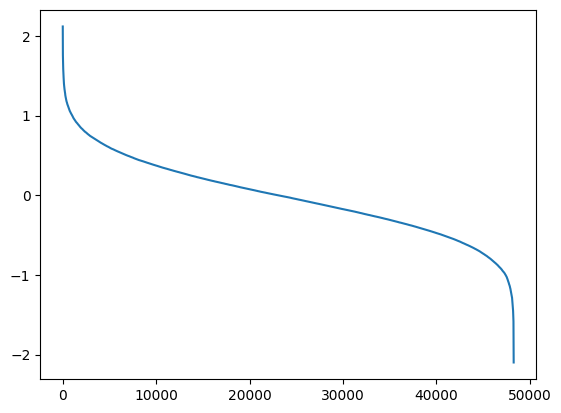

In [ ]:
plt.plot(sorted_vals.detach().cpu().numpy())

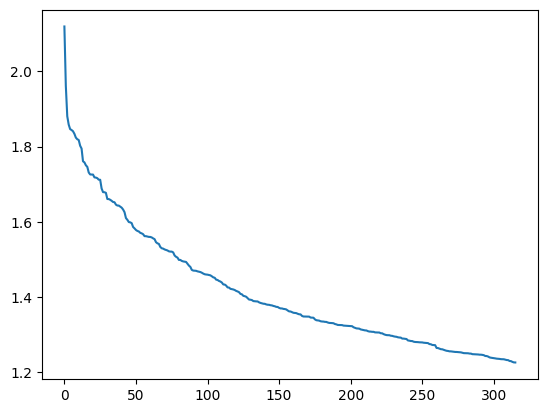

In [ ]:
plt.plot(sorted_vals.detach().cpu().numpy()[:158*2])

In [ ]:
sorted_vals, sorted_indices = torch.sort(model.W_E @ feature_mid1, descending=True)

In [ ]:
torch.arange(len(sorted_vals))[sorted_indices.to('cpu') == model.to_single_token(" '")]

tensor([158])

Looks like the direct path to the unembeddings from MLP1 doesn't bear any interpretable fruit; certainly, these are not the tokens that we'd expect from the top activating examples. Can we use this to create an adversarial prompt?

In [ ]:
def to_token_list(prompt): return model.tokenizer.batch_decode(model.tokenizer.encode(prompt))

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "        {'name': 'John'}", feature_idx, layer=1)

array([0.       , 0.       , 0.       , 0.       , 0.       , 4.9294744,
       0.       , 0.       ], dtype=float32)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "test': inex", feature_idx, layer=1, prepend_bos=False)

array([0.       , 0.7571433, 0.       ], dtype=float32)

Nope, no dice. Looks like the direct path doesn't do much. What about the path through MLP0?

### Understand weird feature

Per Neel's advice: patch direct path, interpolating between a token we understand (i.e. ` '`) and a token we don't (i.e. ` inex`).

In [ ]:
interp_scores = []

In [ ]:
ln2_mlp_until_out(model.W_E[model.to_single_token(" '")][None, None, :] + model.W_pos[40],
    model.blocks[1].ln2, model.blocks[1].mlp
) @ feature_l1_out

tensor([[-4.0707]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [ ]:
ln2_mlp_until_out(model.W_E[model.to_single_token(" inex")][None, None, :] + model.W_pos[40],
    model.blocks[1].ln2, model.blocks[1].mlp
) @ feature_l1_out

tensor([[2.0925]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [ ]:
ln2_mlp_until_out(model.W_E[model.to_single_token(" enorm")][None, None, :], model.blocks[1].ln2, model.blocks[1].mlp) @ feature_l1_out

tensor([[1.0065]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [ ]:
@torch.no_grad()
def activation_steering(model, prompt, steering_info, measure_info, encoder=None):
    # steering_info: {'layer', 'act_name', 'token', 'vec'}
    # if use_sae: measure_info is like {'layer', 'act_name', 'token', 'feature_idx'}
    # otherwise, measure_info is like {'layer', 'act_name', 'token', 'vec'}
    def steer_hook_fn(activation, hook):
        new_activation = activation.clone()
        new_activation[0,steering_info['token']] = activation[0,steering_info['token']] + steering_info['vec']
        return new_activation
    measure_act_str = utils.get_act_name(measure_info['act_name'], measure_info['layer'])
    steering_act_str = utils.get_act_name(steering_info['act_name'], measure_info['layer'])
    
    _, cache_unsteered = model.run_with_cache(prompt, names_filter=[steering_act_str, measure_act_str])
    with model.hooks(fwd_hooks=[(steering_act_str, steer_hook_fn)]):
        _, cache_steered = model.run_with_cache(prompt, names_filter=[steering_act_str, measure_act_str])
    
    if encoder is not None:
        _, _, unsteered_hidden_acts, _, _ = encoder(cache_unsteered[measure_act_str])
        _, _, steered_hidden_acts, _, _ = encoder(cache_steered[measure_act_str])
        unsteered_score = unsteered_hidden_acts[0, measure_info['token'], measure_info['feature_idx']].item()
        steered_score = steered_hidden_acts[0, measure_info['token'], measure_info['feature_idx']].item()
    else:
        unsteered_score = (cache_unsteered[measure_act_str][0, measure_info['token']] @ measure_info['vec']).item()
        steered_score = (cache_steered[measure_act_str][0, measure_info['token']] @ measure_info['vec']).item()
    return unsteered_score, steered_score

In [ ]:
token_df_sorted = token_df.sort_values("feature", ascending=False).head(100)
linear_sum = 0
count = 0
for cur_example, cur_pos in zip(token_df_sorted['batch'].iloc, token_df_sorted['pos'].iloc):
    linear_sum += get_feature_mid(all_tokens, cur_example, cur_pos, feature_l1_out, use_ln=True, layer=1)
    count += 1
linear_sum /= count

In [ ]:
plot_top_tokens(model, model.W_E @ linear_sum)

,str_tokens,feature_scores
0,·corro,1.844729
1,·deton,1.830441
2,·έ,1.780164
3,·dra,1.778238
4,·VERY,1.759446
5,·unders,1.755786
6,·cripp,1.736280
7,·ign,1.718971
8,·iç,1.690044
9,·immer,1.650971


In [ ]:
def quick_direct_patch(token):
    _, cache = model.run_with_cache("{'name': '")
    clean_act = cache[utils.get_act_name('resid_mid', 1)]
    dirty_act = clean_act.clone()
    dirty_act[0,-1,:] = dirty_act[0,-1,:] - model.W_E[model.to_single_token(" '")] + model.W_E[model.to_single_token(token)]
    _, _, hidden_clean, _, _ = encoder_l1(ln2_mlp_until_out(clean_act, model.blocks[1].ln2, model.blocks[1].mlp)[0,-1])
    _, _, hidden_dirty, _, _ = encoder_l1(ln2_mlp_until_out(dirty_act, model.blocks[1].ln2, model.blocks[1].mlp)[0,-1])
    return hidden_dirty[feature_idx] - hidden_clean[feature_idx]

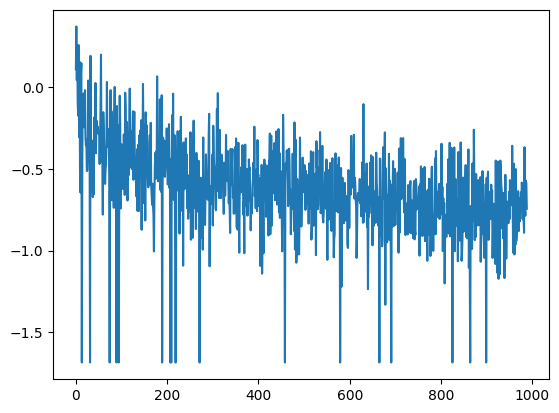

In [ ]:
quick_patch_results = []

for token in get_top_tokens(model.tokenizer, model.W_E @ linear_sum, k=1000)[1]:
    try:
        quick_patch_results.append(quick_direct_patch(token).item())
    except: pass

plt.plot(quick_patch_results)

In [ ]:
@torch.no_grad()
def quick_direct_patch_interp(token, t):
    _, cache = model.run_with_cache("{'name': '")
    clean_act = cache[utils.get_act_name('resid_mid', 1)]
    dirty_act = clean_act.clone()
    dirty_act[0,-1,:] = dirty_act[0,-1,:] - t*model.W_E[model.to_single_token(" '")] + t*model.W_E[model.to_single_token(token)]
    _, _, hidden_clean, _, _ = encoder_l1(ln2_mlp_until_out(clean_act, model.blocks[1].ln2, model.blocks[1].mlp)[0,-1])
    _, _, hidden_dirty, _, _ = encoder_l1(ln2_mlp_until_out(dirty_act, model.blocks[1].ln2, model.blocks[1].mlp)[0,-1])
    return (hidden_dirty[feature_idx] - hidden_clean[feature_idx]).item()

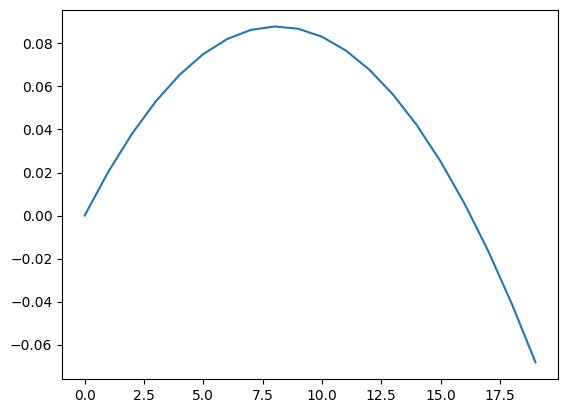

In [ ]:
quick_interp_results = []
for t in np.arange(0, 1, 0.05):
    quick_interp_results.append(quick_direct_patch_interp(' VERY', t))
plt.plot(quick_interp_results)

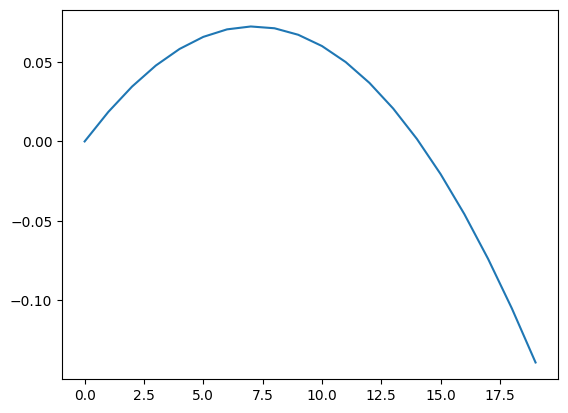

In [ ]:
quick_interp_results = []
for t in np.arange(0, 1, 0.05):
    quick_interp_results.append(quick_direct_patch_interp(' unders', t))
plt.plot(quick_interp_results)

In [ ]:
quick_direct_patch_interp(' VERY', 0)

0.0

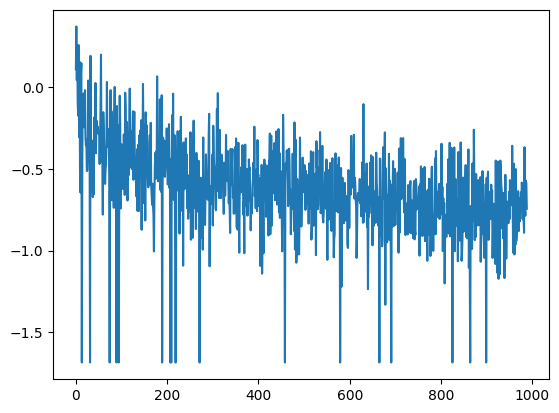

In [ ]:
quick_patch_results = []

for token in get_top_tokens(model.tokenizer, model.W_E @ linear_sum, k=1000)[1]:
    try:
        quick_patch_results.append(quick_direct_patch(token).item())
    except: pass

plt.plot(quick_patch_results)

## DLA

In [ ]:
@torch.no_grad()
def dla(model, input, layer, range_normal, dst_token=-1, mid=False):
    _, cache = model.run_with_cache(input)
    dlas = []
    print(cache[utils.get_act_name('attn_out', 0)].shape)
    dlas.append(
        ( (cache[utils.get_act_name('resid_pre', 0)][:,dst_token] @ range_normal).item(), ('resid_pre', 0) )
    )
    for cur_layer in range(layer):
        dlas.append(
            ( (cache[utils.get_act_name('attn_out', cur_layer)][:,dst_token] @ range_normal).item(), ('attn_out', cur_layer) )
        )
        dlas.append(
            ( (cache[utils.get_act_name('mlp_out', cur_layer)][:,dst_token] @ range_normal).item(), ('mlp_out', cur_layer) )
        )
        
    if mid:
        dlas.append(
            ( (cache[utils.get_act_name('attn_out', layer)][:,dst_token] @ range_normal).item(), ('attn_out', layer) )
        )
    return dlas

In [ ]:
dla(model, all_tokens[feature_example_idx], 1, feature_mid1, dst_token=feature_token_idx, mid=True)

torch.Size([1, 128, 512])


[(1.0699691772460938, ('resid_pre', 0)),
 (1.339957356452942, ('attn_out', 0)),
 (2.658581256866455, ('mlp_out', 0)),
 (-5.068460941314697, ('attn_out', 1))]

In [ ]:
# try on a different example: 1976/116
dla(model, all_tokens[1976], 1, feature_mid1, dst_token=116, mid=True)

torch.Size([1, 128, 512])


[(1.1132079362869263, ('resid_pre', 0)),
 (1.563636064529419, ('attn_out', 0)),
 (2.609280824661255, ('mlp_out', 0)),
 (-3.358752489089966, ('attn_out', 1))]

In [ ]:
print(model.tokenizer.decode(all_tokens[feature_example_idx,:feature_token_idx+1]))

<|BOS|>IN: {
            'country': 'de,cn,dk',
            'city': '


## Express layer1 feature in terms of layer0 features

In [ ]:
encoder_l0 = AutoEncoder.load_from_hf("gelu-2l_L0_16384_mlp_out_51")

{'act_name': 'blocks.0.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'device': 'cuda:1',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 0,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 51,
 'seq_len': 128,
 'site': 'mlp_out'}


### Propagate feature into SAE

In [ ]:
encoder_l0.W_dec.shape

torch.Size([16384, 512])

In [ ]:
feature_mid1.shape

torch.Size([512])

In [ ]:
mlp0_feature_coeffs = encoder_l0.W_dec @ feature_mid1

In [ ]:
torch.linalg.norm(mlp0_feature_coeffs, ord=1)

tensor(2020.3749, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
top_mlp0_coeffs, top_mlp0_coeff_indices = torch.sort(mlp0_feature_coeffs)
top_mlp0_coeffs, top_mlp0_coeff_indices

(tensor([-0.5067, -0.4876, -0.4857,  ...,  0.5068,  0.5350,  0.6452],
        device='cuda:0', grad_fn=<SortBackward0>),
 tensor([ 3016, 12675,  8064,  ..., 11265,  4044,    81], device='cuda:0'))

In [ ]:
top_mlp0_coeffs[-4], top_mlp0_coeff_indices[-4]

(tensor(0.5014, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(10630, device='cuda:0'))

### Look at high-scoring features

In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[:128*100], 81, batch_size=128, layer=0)

100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


In [ ]:
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
567082,·',·'/42,"6',·'null':|·'|True",4430,42,4430/42,6.402344
1073703,·',·'/39,"5',·'null':|·'|True",8388,39,8388/39,6.355469
242492,·',·'/60,"0',·'null':|·'|True",1894,60,1894/60,6.355469
1073743,·',·'/79,"5',·'null':|·'|True",8388,79,8388/79,6.339844
25131,·',·'/43,"5',·'null':|·'|True",196,43,196/43,6.320312
491058,·',·'/50,"0',·'null':|·'|True",3836,50,3836/50,6.312500
227646,·',·'/62,"8',·'null':|·'|True",1778,62,1778/62,6.269531
242531,·',·'/99,"0',·'null':|·'|True",1894,99,1894/99,6.261719
232473,·',·'/25,"0',·'null':|·'|True",1816,25,1816/25,6.203125
1624606,·',·'/30,"',·[],·{'null':|·'|True",12692,30,12692/30,6.187500


In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[:128*100], 4044, batch_size=128, layer=0)

100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


In [ ]:
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
1288077,>,>/13,ples.py·|···,10063,13,10063/13,8.039062
1116174,>,>/14,"SZ"">↩ ········|GN",8720,14,8720/14,7.753906
323988,>,>/20,>·:·|·<,2531,20,2531/20,7.691406
610021,>,>/101,"↩ ··············""······|0",4765,101,4765/101,7.671875
1007083,>,>/107,"exact"">↩ ············|q",7867,107,7867/107,7.664062
250809,>,>/57,*(?P|[^,1959,57,1959/57,7.636719
323983,>,>/15,↩ ········#···|·:,2531,15,2531/15,7.609375
630978,>,>/66,".0""?>|http",4929,66,4929/66,7.554688
1514141,>,>/29,·[score=||,11829,29,11829/29,7.542969
406029,>,>/13,"/"">↩ ··|7",3172,13,3172/13,7.527344


In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[:128*100], 11265, batch_size=128, layer=0)
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

100%|██████████| 100/100 [00:05<00:00, 18.01it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
307843,"=""","=""/3","<|BOS|>↩ ····url|=""|https",2405,3,2405/3,6.980469
181265,"=""","=""/17","xsd:enumeration·value|=""|LOAD",1416,17,1416/17,6.960938
56321,"=""","=""/1","<|BOS|>|=""|password",440,1,440/1,6.761719
1068929,"=""","=""/1","<|BOS|>|=""|"")",8351,1,8351/1,6.761719
18945,"=""","=""/1","<|BOS|>|=""|on",148,1,148/1,6.761719
1385217,"=""","=""/1","<|BOS|>|=""|icon",10822,1,10822/1,6.761719
88577,"=""","=""/1","<|BOS|>|=""|false",692,1,692/1,6.761719
1012609,"=""","=""/1","<|BOS|>|=""|duration",7911,1,7911/1,6.761719
1567745,"=""","=""/1","<|BOS|>|=""|R",12248,1,12248/1,6.761719
797825,"=""","=""/1","<|BOS|>|=""|%",6233,1,6233/1,6.761719


In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[:128*100], 10630, batch_size=128, layer=0)
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
19976,�,�/8,·operation.↩ ��|�|·Dam,156,8,156/8,4.191406
20016,�,�/48,·crack).↩ ��|�|·O,156,48,156/48,4.152344
1274020,�,�/36,سباران�|�|·or,9953,36,9953/36,3.958984
1369522,�,�/50,·first·episode.↩ �|�|·That,10699,50,10699/50,3.794922
20080,�,�/112,·cylinder.↩ ��|�|·Inc,156,112,156/112,3.761719
1369510,�,�/38,·Fantasy·XV.↩ �|�|·And,10699,38,10699/38,3.640625
1373868,�,�/44,█��··�|�|█,10733,44,10733/44,3.578125
1373862,�,�/38,█��··�|�|█,10733,38,10733/38,3.521484
1373840,�,�/16,·����·�|�|█,10733,16,10733/16,3.494141
175723,�,�/107,$MM/······�|�|�,1372,107,1372/107,3.458984


Now look at features with most negative coefficients

In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[:128*100], 3016, batch_size=128, layer=0)
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
870058,·Phil,·Phil/42,".↩ Unfortunately·however,|·Phil|ips",6797,42,6797/42,13.570312
1560913,·Phil,·Phil/81,·using·technology·at·all.|·Phil|ips,12194,81,12194/81,13.304688
721246,·Phil,·Phil/94,·he·had·a·daughter·named|·Phil|a,5634,94,5634/94,13.156250
744154,·Phil,·Phil/90,·as·well·but·will·ask|·Phil|·about,5813,90,5813/90,12.570312
870138,·Phil,·Phil/122,",·but·in·my·opinion|·Phil|ips",6797,122,6797/122,10.804688
1497547,Phil,Phil/75,·their·meal·preparation.↩ |Phil|·Heath,11699,75,11699/75,9.828125
1497565,·Phil,·Phil/93,ia·2018|·Phil|·Heath,11699,93,11699/93,9.578125
721274,·Phil,·Phil/122,·proof·we·can·find·that|·Phil|a,5634,122,5634/122,9.546875
2110,·Nicolas,·Nicolas/62,.·Uveous·following|·Nicolas|·engages,16,62,16/62,1.685547
1559412,·Chrys,·Chrys/116,"·earlier·in·the·thread,|·Chrys|alis",12182,116,12182/116,1.646484


The top feature seems extremely interpretable, and very much in keeping with what the second-layer feature that we're investigating does. But what's with all these other features? One possibility is that there's a form of "superposition" going on, where all of these features cancel each other out in just the right way so as to leave only the top feature remaining.

Thus, instead of trying to directly compute $c$ (the vector of feature coefficients), we can try and find a "sparsified" version of $c$: a vector $c'$ such that $c'$ has low L1 norm but $c-c'$ has low L2 norm.

### Sparsify

In [ ]:
def sparsify(x, l1_coeff=0.01, lr=0.05, eps=0.00001, max_steps=10000):    
    x_new = x.detach().clone()
    x_new.requires_grad_(True)
    
    optimizer = torch.optim.Adam([x_new], lr=lr)

    loss_func = lambda x_new: (torch.linalg.norm(x.detach()-x_new))**2 + l1_coeff*torch.linalg.norm(x_new, ord=1)
    
    loss = None
    prev_loss = None
    steps = 0
    while (loss is None or abs(loss.item()) > eps) and (max_steps is None or steps < max_steps):
        optimizer.zero_grad()
        prev_loss = loss
        loss = loss_func(x_new)
        if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps: break
        loss.backward()
        optimizer.step()
        steps += 1
    return x_new, ((torch.linalg.norm(x.detach()-x_new))**2).item(), torch.linalg.norm(x_new, ord=1).item()

In [ ]:
def sparsify_cossim(x, l1_coeff=0.01, lr=0.05, eps=0.00001, max_steps=10000, max_steps_lr=True):    
    x_new = x.detach().clone()
    x_new.requires_grad_(True)
    
    optimizer = torch.optim.Adam([x_new], lr=lr)

    # todo: replace 1-cossim^2 with -arccos(cossim)?
    cossim_loss = lambda x_new: (1 - cossim(x.detach(), x_new)**2)
    l1_loss = lambda x_new: l1_coeff*torch.linalg.norm(x_new, ord=1)
    loss_func = lambda x_new: cossim_loss(x_new) + l1_loss(x_new)

    if max_steps_lr and max_steps is not None: max_steps = int(max_steps/lr)
    
    loss = None
    prev_loss = None
    steps = 0
    while (loss is None or abs(loss.item()) > eps) and (max_steps is None or steps < max_steps):
        optimizer.zero_grad()
        prev_loss = loss
        loss = loss_func(x_new)
        if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps:
            print(f"Quit on step {steps}")
            break
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            x_new[:] = x_new/torch.linalg.norm(x_new) # enforce unit norm
        steps += 1
    return x_new, cossim_loss(x_new).item(), torch.linalg.norm(x_new, ord=1).item()

In [ ]:
mlp0_feature_coeffs_new, squared_error, l1_norm = sparsify(mlp0_feature_coeffs, lr=0.001, l1_coeff=0.25)

In [ ]:
mlp0_feature_coeffs_new, cossim_loss, l1_norm = sparsify_cossim(mlp0_feature_coeffs, lr=0.001, l1_coeff=0.0015)

Quit on step 164


In [ ]:
cossim_loss, l1_norm

(0.06573528051376343, 95.32945251464844)

In [ ]:
top_mlp0_coeffs_new, top_mlp0_coeff_indices_new = torch.sort(mlp0_feature_coeffs_new)
top_mlp0_coeffs_new, top_mlp0_coeff_indices_new

(tensor([-0.0415, -0.0305, -0.0299,  ...,  0.0416,  0.0728,  0.2754],
        device='cuda:0', grad_fn=<SortBackward0>),
 tensor([ 3016, 12675,  8064,  ..., 11265,  4044,    81], device='cuda:0'))

In [ ]:
mlp0_feature_coeffs_new, cossim_loss, l1_norm = sparsify_cossim(mlp0_feature_coeffs, lr=0.001, l1_coeff=0.0015)
print(cossim_loss, l1_norm)

top_mlp0_coeffs_new, top_mlp0_coeff_indices_new = torch.sort(mlp0_feature_coeffs_new)
print(top_mlp0_coeffs_new, top_mlp0_coeff_indices_new)
print(l1_norm/top_mlp0_coeffs_new[-1].item())

Quit on step 164
0.06573528051376343 95.32945251464844
tensor([-0.0415, -0.0305, -0.0299,  ...,  0.0416,  0.0728,  0.2754],
       device='cuda:0', grad_fn=<SortBackward0>) tensor([ 3016, 12675,  8064,  ..., 11265,  4044,    81], device='cuda:0')
346.14785038247805


### Compare linearized coefficients with activation steering results

## MLP1 <- MLP0

In [25]:
feature_mlp1_mlp0_noln = get_feature_mid(all_tokens, feature_example_idx, feature_token_idx, feature_mid1, use_ln=False, layer=0)

NameError: name 'feature_mid1' is not defined

In [ ]:
feature_mlp1_mlp0 = get_feature_mid(all_tokens, feature_example_idx, feature_token_idx, feature_mid1, use_ln=True, layer=0)

In [ ]:
cossim(feature_mlp1_mlp0_noln, feature_mlp1_mlp0)

tensor(0.9116, device='cuda:0')

### Token unembeddings

In [ ]:
plot_top_tokens(model, model.W_E @ feature_mlp1_mlp0_noln)

,str_tokens,feature_scores
0,=”,2.397212
1,"=""'",2.359721
2,':',2.277151
3,"·""'",2.264651
4,"=""",2.203285
5,\),2.179667
6,"—""",2.169569
7,",—",2.165967
8,"-""",2.160001
9,"""...",2.158100


In [ ]:
plot_top_tokens(model, model.W_E @ feature_mlp1_mlp0)

,str_tokens,feature_scores
0,"""...",5.604253
1,"=""'",5.558907
2,",""",5.370593
3,\),5.219321
4,=”,5.179338
5,"-""",5.170648
6,·---------------------,5.165444
7,"·""\",5.092072
8,·Г,5.063296
9,^[,5.023333


Nice! Now we're getting somewhere!

In [ ]:
sorted_vals, sorted_indices = torch.sort(model.W_E @ feature_mlp1_mlp0, descending=True)

In [ ]:
torch.arange(len(sorted_vals))[sorted_indices.to('cpu') == model.to_single_token(" '")]

tensor([101])

### Top examples

In [ ]:
scores = get_dot_scores(model, all_tokens[:128*100], feature_mlp1_mlp0, batch_size=128, layer=0, act_name='resid_mid')
tokens = all_tokens[:128*100]
token_df = make_token_df(tokens)
token_df["feature"] = scores.reshape(-1,)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
394469,·',·'/101,_EXTENSIBLE·=|·'|Ext,3081,101,3081/101,3.529297
796024,"""","""/120","↩ #4·:·u|""|av",6218,120,6218/120,3.300781
1178960,·',·'/80,"',·[],·{'unique':|·'|True",9210,80,9210/80,3.199219
1273191,·',·'/103,"',·[],·{'unique':|·'|True",9946,103,9946/103,3.148438
1446843,·',·'/59,"',·[],·{'unique':|·'|True",11303,59,11303/59,3.107422
1467854,"""","""/78","A·rich·lunatic,\|""|·they",11467,78,11467/78,3.103516
1060149,','/53,·u'ą':·u|'|a,8282,53,8282/53,3.046875
796005,"""","""/101","↩ #2·:·u|""|f",6218,101,6218/101,3.039062
796015,"""","""/111","↩ #3·:·u|""|m",6218,111,6218/111,3.021484
658538,','/106,"downarrow'·················:·r|'|',",5144,106,5144/106,3.005859


There are some similarities between this path's feature and the original one. In particular, this path's feature seems to fire on a larger number of "open string delimiter in a key-value context" tokens; compare to the original one, which fired on primarily the ` '` token.

## mlp1 <- attn0

### Attention attribution

In [ ]:
def get_attn_head_contribs(model, cache, layer, range_normal):
	split_vals = cache[utils.get_act_name('v', layer)]
	attn_pattern = cache[utils.get_act_name('pattern', layer)]
	#'batch head dst src, batch src head d_head -> batch head dst src d_head'
	weighted_vals = torch.einsum(
		'b h d s, b s h f -> b h d s f',
		attn_pattern, split_vals
	)

  # 'batch head dst src d_head, head d_head d_model -> batch head dst src d_model'
	weighted_outs = torch.einsum(
		'b h d s f, h f m -> b h d s m',
		weighted_vals, model.W_O[layer]
	)

  # 'batch head dst src d_model, d_model -> batch head dst src'
	contribs = torch.einsum(
		'b h d s m, m -> b h d s',
		weighted_outs, range_normal
	)

	return contribs

def get_attn_head_contribs_ov(model, cache, layer, range_normal):
	split_vals = cache[utils.get_act_name('v', layer)]

  # 'batch src head d_head, head d_head d_model -> batch head src d_model'
	weighted_outs = torch.einsum(
		'b s h f, h f m -> b h s m',
		split_vals, model.W_O[layer]
	)

  # 'batch head src d_model, d_model -> batch head src'
	contribs = torch.einsum(
		'b h s m, m -> b h s',
		weighted_outs, range_normal
	)

	return contribs

In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [ ]:
def plot_attn_contribs_for_example(model, example_idx, token_idx, feature_mid, start_token_idx=0, ov_only=False, layer=0):
  with torch.no_grad():
    tokens = all_tokens[example_idx]
    _, cache = model.run_with_cache(tokens, names_filter=[
        utils.get_act_name("pattern", layer),
        utils.get_act_name('v', layer),
    ])
    if not ov_only:
      attn_contribs = get_attn_head_contribs(model, cache, layer, feature_mid)
      attn_contribs_window = attn_contribs[0,:,token_idx,start_token_idx:token_idx+1]
    else:
      attn_contribs = get_attn_head_contribs_ov(model, cache, layer, feature_mid)
      attn_contribs_window = attn_contribs[0,:,start_token_idx:token_idx+1]
    print(attn_contribs_window.sum().item())
    fig = px.imshow(
        utils.to_numpy(attn_contribs_window),
        x = list(map(lambda x, i: f"|{process_token(x)}| pos {str(i)}",
                     model.tokenizer.batch_decode(tokens[start_token_idx:token_idx+1]),
                     range(start_token_idx, token_idx+1))),
        color_continuous_midpoint = 0
      )
    fig.update_xaxes(tickangle=90)
  fig.show()

In [ ]:
def plot_attn_pattern_for_example(model, example_idx, token_idx, start_token_idx=0, layer=0):
  with torch.no_grad():
    tokens = all_tokens[example_idx]
    _, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=[
        utils.get_act_name("pattern", layer),
    ])
    fig = px.imshow(
        utils.to_numpy(cache[utils.get_act_name("pattern", layer)][0,:,token_idx,start_token_idx:token_idx+1]),
        x = list(map(lambda x, i: f"|{process_token(x)}| pos {str(i)}",
                     model.tokenizer.batch_decode(tokens[start_token_idx:token_idx+1]),
                     range(start_token_idx, token_idx+1))),
        color_continuous_midpoint = 0
      )
    fig.update_xaxes(tickangle=90)
  fig.show()

In [ ]:
plot_attn_contribs_for_example(model, feature_example_idx, feature_token_idx, feature_mid1, start_token_idx=1)

1.8599666357040405


In [ ]:
plot_attn_contribs_for_example(model, 6163, 22, feature_mid1, start_token_idx=1)

2.018665313720703


The pattern here seems obvious: head 2 fires on the token `':` in the previous position. 

In [ ]:
def do_single_token_qk(dst_token_str, src_token_str, head, dst_pos=40, src_pos=40):
    max_pos_list = []
    query = model.W_E[model.to_single_token(dst_token_str)] + model.W_pos[dst_pos]
    query = model.blocks[0].ln1(query)
    query = query @ model.blocks[0].attn.W_Q[head]
    query = query + model.blocks[0].attn.b_Q[head]

    key = model.W_pos[src_pos] + model.W_E[model.to_single_token(src_token_str)]
    key = model.blocks[0].ln1(key)
    key = key @ model.blocks[0].attn.W_K[head]
    key = key + model.blocks[0].attn.b_K[head]
        
    test_qk = query @ key.T
    return test_qk.item()

In [ ]:
do_single_token_qk(" '", "':", 2, dst_pos=22, src_pos=21)

/tmp/ipykernel_4109918/1025894170.py:13: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)



46.554771423339844

In [ ]:
do_single_token_qk(" '", "':", 2, dst_pos=22, src_pos=19)

19.805721282958984

### Propagation through attention

In [ ]:
def ln_ov(x, model, layer, head):
  return model.blocks[layer].ln1(x) @ model.OV[layer, head]

In [ ]:
def get_ov_unembed(model, head, feature_mid, ln_token=None, pos_idx=0, layer=0, unembed=True):
  if ln_token is None:
    x = model.OV[layer,head] @ feature_mid
  else:
    x = get_tangent_plane_at_point(
      model.W_E[model.to_single_token(ln_token)] + model.W_pos[pos_idx],
      lambda x: ln_ov(x, model, layer, head), feature_mid)
  if unembed: x = model.W_E @ x
  return x

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 2, feature_mid1, pos_idx=20), k=20)

,str_tokens,feature_scores
0,·Î,0.313672
1,)=\,0.281601
2,))**(,0.277418
3,""":",0.274425
4,':,0.272947
5,·············,0.268238
6,·ن,0.268157
7,·**(,0.264589
8,·val,0.264430
9,=,0.262740


Hmm, not as obvious as initially thought. **TODO**: investigate what the deal is with those top three tokens 

#### What's going on?

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "{'name': 'John'}", feature_idx, layer=1)

array([0.       , 0.       , 0.       , 0.       , 5.2207513, 0.       ,
       0.       ], dtype=float32)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "': '", feature_idx, layer=1)

array([0.      , 0.      , 4.534655], dtype=float32)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "))**( '", feature_idx, layer=1)

array([0.      , 0.      , 1.037777], dtype=float32)

In [ ]:
print(')=\\')

)=\


In [ ]:

get_feature_scores_for_prompt(model, encoder_l1, "'my_val': 'my_fake_dict_assignment: \'key\': \'val\'", feature_idx, layer=1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.073534  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.18053359, 1.8799763 , 0.        , 0.        , 2.4514658 ,
       0.        , 0.        ], dtype=float32)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, ")=\\'", feature_idx, layer=1)

array([0.        , 0.        , 0.40803367], dtype=float32)

In [ ]:
(model.W_E @ feature_mlp1_mlp0_noln)[model.to_single_token('))**(')]

tensor(1.8798, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
(model.W_E @ feature_mlp1_mlp0_noln)[model.to_single_token('\':')]

tensor(1.2148, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
(model.W_E @ feature_mlp1_mlp0_noln)[model.to_single_token(')=\\')]

tensor(1.4836, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
model.tokenizer.batch_decode(model.tokenizer.encode("<|BOS|>)=\ '"))

['<|BOS|>', ')=\\', " '"]

### QK circuits

#### Positional

In [ ]:
plot_attn_contribs_for_example(model, 3976, 42, feature_mid, start_token_idx=1)

NameError: name 'feature_mid' is not defined

In [ ]:
plot_attn_pattern_for_example(model, 3976, 42, start_token_idx=1)

In [ ]:
test_qk = (model.W_E[model.to_single_token(' is')] + model.W_pos[10]  + model.blocks[0].attn.b_Q.reshape(-1)) @ model.QK[0,0] @ model.W_pos.T

In [ ]:
model.blocks[0].attn.W_K.shape

torch.Size([8, 512, 64])

In [ ]:
# TODO: account for ln1
def get_pos_scores(dst_token_str, src_token_str, head, dst_pos=40, use_b_Q=False, use_b_K=False, use_ln=False, pos_lag=0):
    max_pos_list = []
    query = model.W_E[model.to_single_token(dst_token_str)] + model.W_pos[dst_pos]
    if use_ln: query = model.blocks[0].ln1(query)
    query = query @ model.blocks[0].attn.W_Q[head]
    if use_b_Q: query = query + model.blocks[0].attn.b_Q[head]

    key = model.W_pos[:dst_pos+1-pos_lag] + model.W_E[model.to_single_token(src_token_str)]
    if use_ln: key = model.blocks[0].ln1(key)
    key = key @ model.blocks[0].attn.W_K[head]
    if use_b_K: key = key + model.blocks[0].attn.b_K[head]
        
    test_qk = query @ key.T
    return test_qk.detach().cpu().numpy()

In [ ]:
get_pos_scores(' is', 'ism', 4, dst_pos=42, use_b_Q=True, use_b_K=True, use_ln=True).argmax()

42

In [ ]:
# TODO: account for ln1
def get_max_pos_scores(dst_token_str, src_token_str, head, pos_lag=0, end_pos=50, use_b_Q=False, use_b_K=False, use_ln=False):
    max_pos_list = []
    xs = range(pos_lag,end_pos)
    for i in xs:
        test_qk = get_pos_scores(dst_token_str, src_token_str, head,
                                 dst_pos=i, pos_lag=pos_lag, use_b_Q=use_b_Q, use_b_K=use_b_K, use_ln=use_ln)
        max_pos_list.append(test_qk.argmax())
    return xs, max_pos_list

In [ ]:
px.line(get_pos_scores(' is', 'ism', 4, dst_pos=42, use_b_Q=True, use_b_K=True, use_ln=True))

In [ ]:
xs0, ys0 = get_max_pos_scores(' is', 'ism', 4, pos_lag=0, use_b_Q=True, use_b_K=True, use_ln=True)
xs1, ys1 = get_max_pos_scores(' is', 'ism', 4, pos_lag=1, use_b_Q=True, use_b_K=True, use_ln=True)
xs2, ys2 = get_max_pos_scores(' is', 'ism', 4, pos_lag=2, use_b_Q=True, use_b_K=True, use_ln=True)
xs5, ys5 = get_max_pos_scores(' is', 'ism', 4, pos_lag=5, use_b_Q=True, use_b_K=True, use_ln=True)

In [ ]:
fig = px.line(x=xs0, y=ys0, markers=True)
fig.add_scatter(x=list(xs1), y=ys1, mode='lines')
fig.add_scatter(x=list(xs2), y=ys2, mode='lines')
fig.add_scatter(x=list(xs5), y=ys5, mode='lines')

In [ ]:
test_qk_sorted = torch.sort(test_qk)

In [ ]:
test_qk_sorted.values[:50]

tensor([-0.1054, -0.1049, -0.1023, -0.1014, -0.0995, -0.0994, -0.0990, -0.0987,
        -0.0981, -0.0968, -0.0966, -0.0961, -0.0959, -0.0956, -0.0948, -0.0947,
        -0.0937, -0.0923, -0.0919, -0.0917, -0.0915, -0.0901, -0.0898, -0.0889,
        -0.0878, -0.0877, -0.0865, -0.0863, -0.0854, -0.0835, -0.0831, -0.0830,
        -0.0827, -0.0819, -0.0816, -0.0813, -0.0809, -0.0804, -0.0803, -0.0794,
        -0.0794, -0.0794, -0.0794, -0.0790, -0.0788, -0.0786, -0.0782, -0.0781,
        -0.0777, -0.0776], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
torch.arange(model.W_E.shape[0])[test_qk_sorted.indices.cpu() == model.to_single_token(' is')]

tensor([6166])

In [ ]:
test_qk = model.W_E @ model.QK[0,3] @ (model.W_E[model.to_single_token(' is')] + model.W_pos[42])

In [ ]:
test_qk_sorted = torch.sort(test_qk)

In [ ]:
test_qk_sorted.values[:50]

tensor([-0.7098, -0.7070, -0.6414, -0.6291, -0.6259, -0.5964, -0.5914, -0.5628,
        -0.5597, -0.5587, -0.5573, -0.5508, -0.5463, -0.5365, -0.5326, -0.5287,
        -0.5267, -0.5243, -0.5242, -0.5232, -0.5202, -0.5165, -0.5151, -0.5144,
        -0.5132, -0.5123, -0.5109, -0.5108, -0.5104, -0.5095, -0.5083, -0.5047,
        -0.5045, -0.5028, -0.5008, -0.4921, -0.4891, -0.4888, -0.4882, -0.4876,
        -0.4872, -0.4870, -0.4870, -0.4868, -0.4852, -0.4802, -0.4800, -0.4791,
        -0.4780, -0.4778], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
torch.arange(model.W_E.shape[0])[test_qk_sorted.indices.cpu() == model.to_single_token(' is')]

tensor([260])

In [ ]:
test_qk[model.to_single_token(' is')]

tensor(-0.3197, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
(model.W_E[model.to_single_token(' is')] @ model.QK[0,4] @ model.W_E.T)[model.to_single_token(' fundamental')]

tensor(0.0205, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
model.blocks[0].attn.b_Q.shape

torch.Size([8, 64])

In [ ]:
plot_top_tokens(model, (model.W_E[model.to_single_token(' is')] + model.blocks[0].attn.b_Q.reshape(-1)) @\
                model.QK[0,4] @ model.W_E.T, k=10)

,str_tokens,feature_scores
0,·[{,2.915863
1,·ranging,2.870203
2,·difference,2.828176
3,·as,2.821041
4,where,2.661981
5,·overview,2.600946
6,·ranged,2.585863
7,·huh,2.568143
8,Missing,2.551764
9,·terminating,2.526011


## MLP1 <- attn1

### Attention attribution

In [ ]:
plot_attn_contribs_for_example(model, feature_example_idx, feature_token_idx, feature_mid1, start_token_idx=0, layer=1)

-0.3347005844116211


In [ ]:
plot_attn_contribs_for_example(model, 6163, 22, feature_mid1, start_token_idx=1, layer=1)

3.396270990371704


### Propagation through attention

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 2, feature_mid1, pos_idx=20, layer=1), k=20)

,str_tokens,feature_scores
0,·OH,0.928490
1,·todd,0.901769
2,明,0.851172
3,。,0.810539
4,·Present,0.802941
5,·Posted,0.771234
6,·celebrating,0.762030
7,·innate,0.747316
8,·undes,0.746000
9,·present,0.738335


In [ ]:
get_ov_unembed(model, 7, feature_mid1, pos_idx=20, layer=1)[model.to_single_token(" '")]

tensor(0.1426, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
get_ov_unembed(model, 7, feature_mid1, pos_idx=20, layer=1)[model.to_single_token("))**(")]

tensor(0.0378, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
get_ov_unembed(model, 2, feature_mid1, pos_idx=20, layer=1)[model.to_single_token(" '")]

tensor(-0.0435, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
get_ov_unembed(model, 2, feature_mid1, pos_idx=20, layer=1)[model.to_single_token("))**(")]

tensor(0.3124, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 7, feature_mid1_noln, pos_idx=20, layer=1), k=20)

,str_tokens,feature_scores
0,·Loc,1.392262
1,·intric,1.383330
2,·Charg,1.334382
3,·adjacent,1.316604
4,·identical,1.307450
5,·Several,1.272371
6,Stud,1.257172
7,Ser,1.250190
8,·hundred,1.236800
9,·Joint,1.234971


#### Propagate through mlp0

In [ ]:
plot_top_tokens(model, model.W_E @ 
    get_feature_mid(all_tokens, feature_example_idx, feature_token_idx,
        get_ov_unembed(model, 2, feature_mid1_noln, pos_idx=20, layer=1, unembed=False),
    use_ln=False, layer=0)
)

,str_tokens,feature_scores
0,·monop,0.804559
1,·emb,0.797918
2,·signific,0.792857
3,·epist,0.785577
4,·fac,0.777035
5,·exper,0.773533
6,·Mic,0.740630
7,·intram,0.738781
8,ウ,0.737996
9,·neuro,0.721916


In [ ]:
feature_mlp1_attn1h7_mlp0 = get_feature_mid(all_tokens, feature_example_idx, feature_token_idx,
        get_ov_unembed(model, 7, feature_mid1_noln, pos_idx=20, layer=1, unembed=False),
    use_ln=False, layer=0)

In [ ]:
plot_attn_contribs_for_example(model, feature_example_idx, feature_token_idx, feature_mlp1_attn1h7_mlp0, start_token_idx=1)

0.590697705745697


## MLP1 <- MLP0 <- attn0

### Attention attribution

In [ ]:
plot_attn_contribs_for_example(model, feature_example_idx, feature_token_idx, feature_mlp1_mlp0_noln, start_token_idx=1)

0.24326103925704956


In [ ]:
plot_attn_contribs_for_example(model, 6163, 22, feature_mlp1_mlp0_noln, start_token_idx=1)

0.22126704454421997


### Propagation through attention

In [ ]:
cossim(get_ov_unembed(model, 2, feature_mlp1_mlp0_noln, pos_idx=20), get_ov_unembed(model, 2, feature_mid1, pos_idx=20))

tensor(-0.1747, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 2, feature_mlp1_mlp0_noln, pos_idx=20), k=20)

,str_tokens,feature_scores
0,':,0.204337
1,·):,0.198757
2,[-,0.196160
3,·perhaps,0.195751
4,”:,0.194566
5,""":",0.193240
6,:*,0.189774
7,'):,0.188667
8,",-",0.188227
9,]:,0.187440


Here, the top token aligns with what we would expect

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "{'name': 'John'}", feature_idx, layer=1)

array([0.       , 0.       , 0.       , 0.       , 5.2207484, 0.       ,
       0.       ], dtype=float32)